# Brute-force detection of a time step

Imagine a timeseries that consists of 2 plateaux connected by a short down ramp.

The frequency distribution of such a timeseries will have 2 humps: one centered on the values of the first plateau level, the other centred on those of the second plateau.

We can measure how well a timeseries $S$ fits this model, i.e. to what extent is has a bimodal frequency distribution, by:

- considering it as two subseries $S = [A, B]$ split at an arbitrary point
- computing the difference between the standard deviations $\sigma(S)-\sigma(A)-\sigma(B)$
- maximising this difference over all possible bisections

In addition, to find series that step down rather than up we can stipulate that $E(A)>E(B)$

I've executed this below for the "total items" timeseries at the BNF chemical level.

NB my database only has data from April 2013 onwards.

In [1]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq # my local stuff

Populating the interactive namespace from numpy and matplotlib


# Get the data from BigQuery

In [58]:
df=gbq.query(
    '''
    select PERIOD,BNF_CHEMICAL,sum(ACT_COST) TOTAL_ACT_COST,sum(ITEMS) TOTAL_ITEMS
    from [nhs.PDPI2]
    group by PERIOD,BNF_CHEMICAL
    ''',
    max_rows=100000,index=['BNF_CHEMICAL','PERIOD'],cast={'TOTAL_ACT_COST':float,'TOTAL_ITEMS':float},
    cachedir='/var/gbq'
)

Reading cached results from /var/gbq/5387133a1c9b5c4874f042be99b793bb.json
68636 rows converted to DataFrame in 0.23 seconds


In [59]:
df.head()

,,TOTAL_ACT_COST,TOTAL_ITEMS
BNF_CHEMICAL,PERIOD,,
0301011R0,201411,4620925.21,1780397
0309020D0,201411,42220.20,48409
040201060,201411,455952.71,167957
0403040F0,201411,33463.48,12180
0405010P0,201411,1040290.38,38104


# Apply the scoring and plot the highest scoring chemicals

I'm looking for steps in TOTAL_ITEMS - plotted in green. I also include TOTAL_ACT_COST - in blue with its scale on the right - in case it's useful.

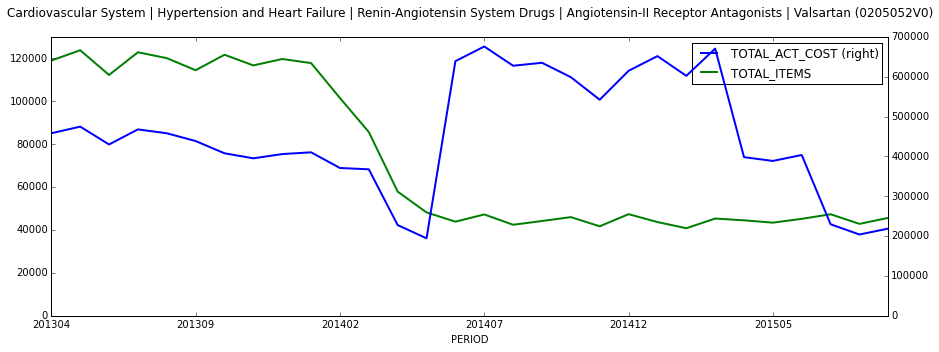

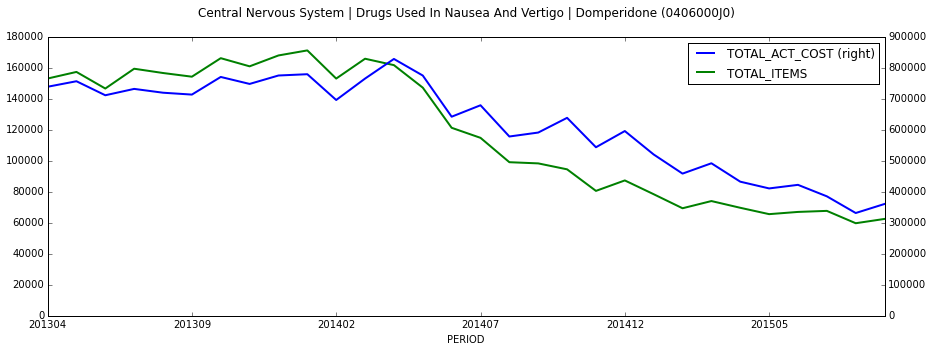

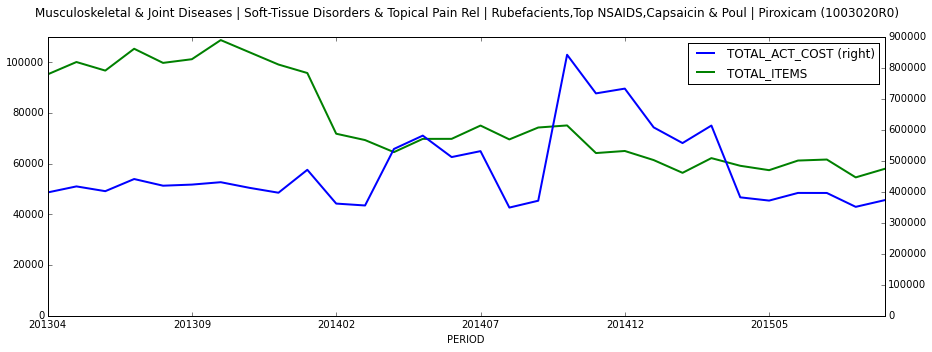

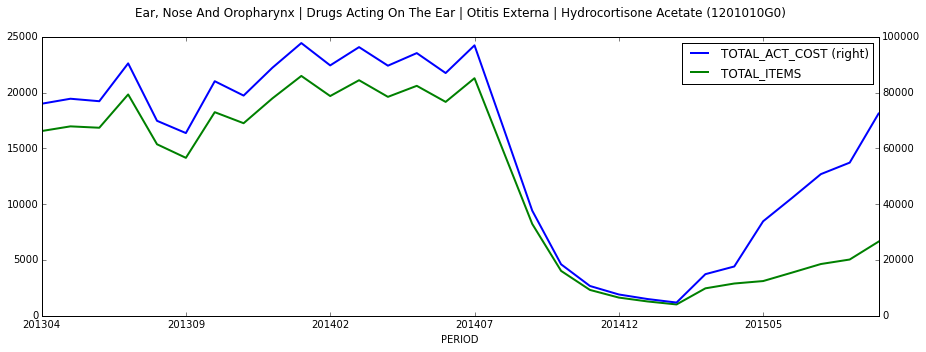

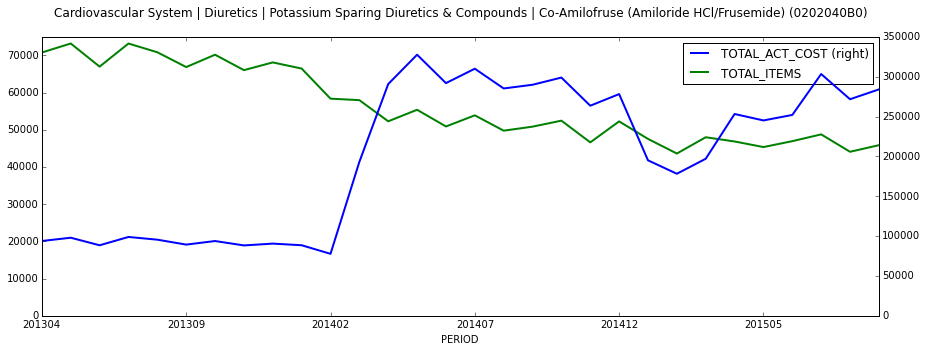

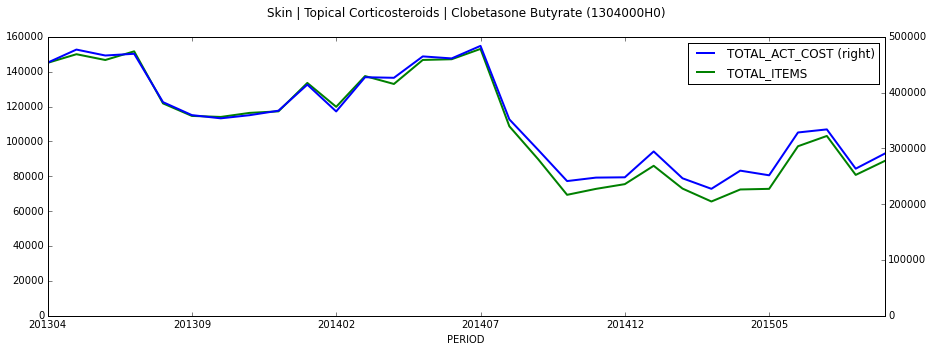

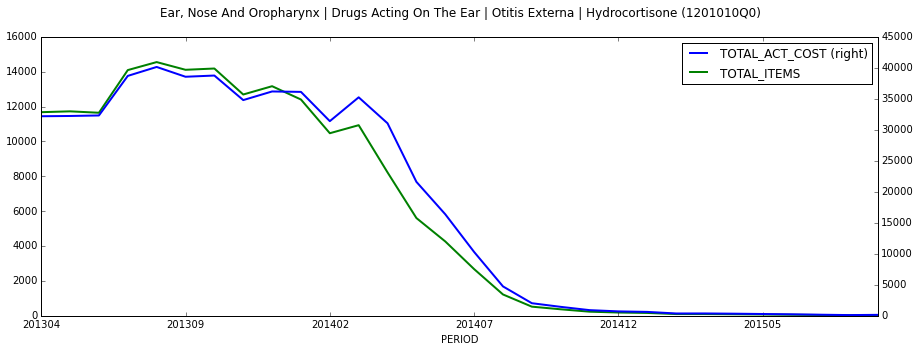

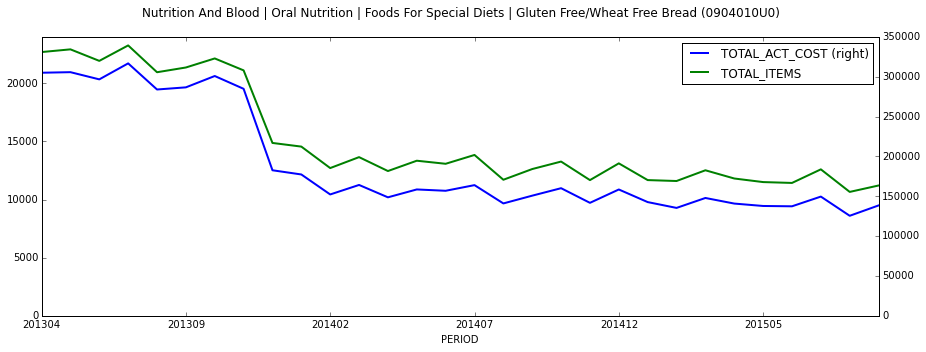

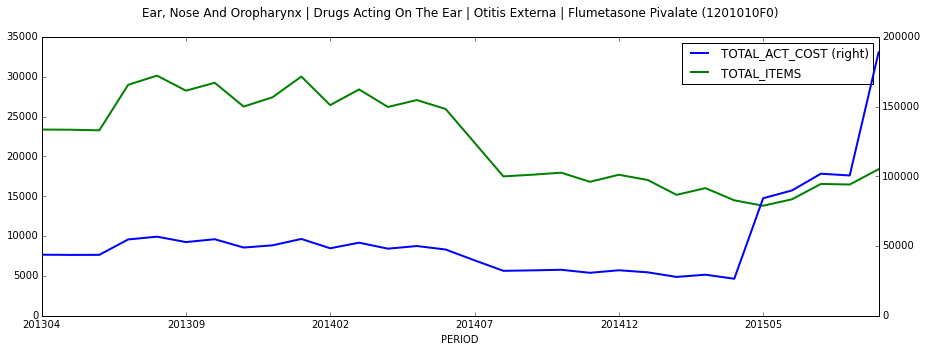

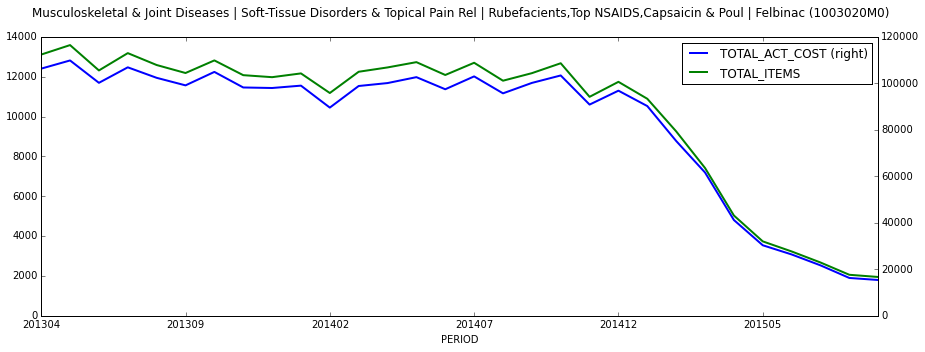

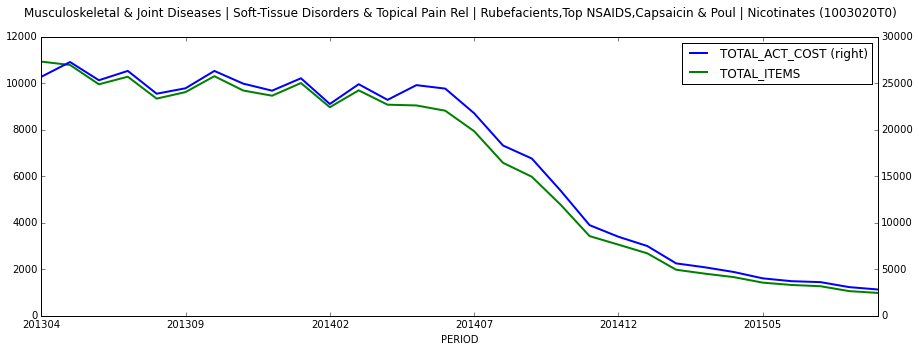

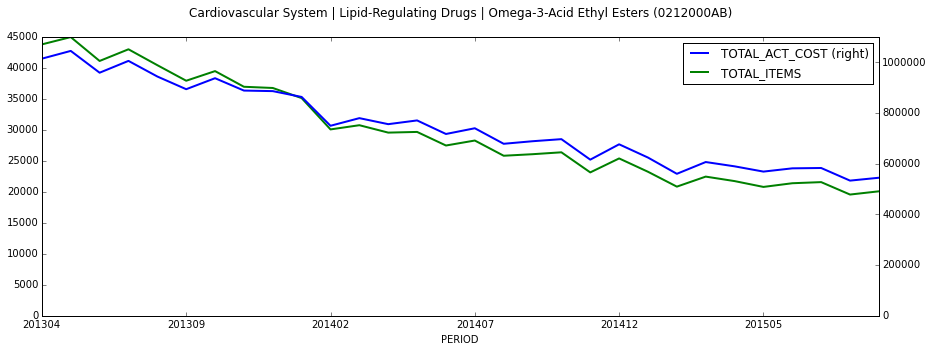

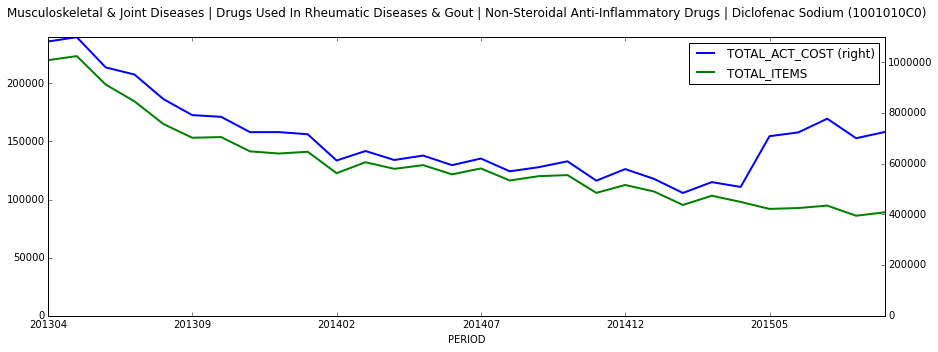

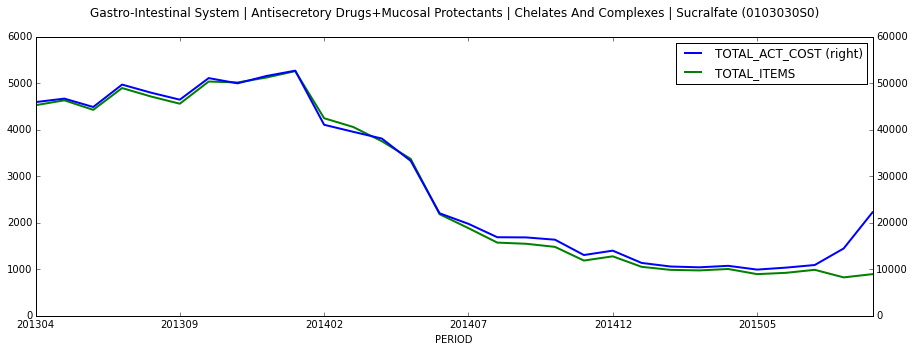

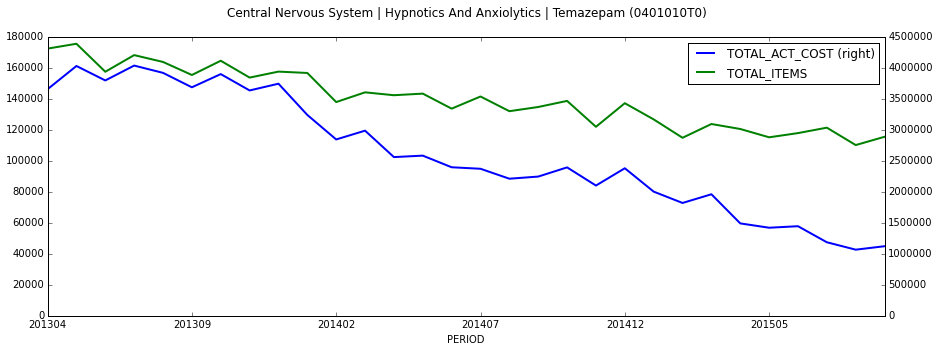

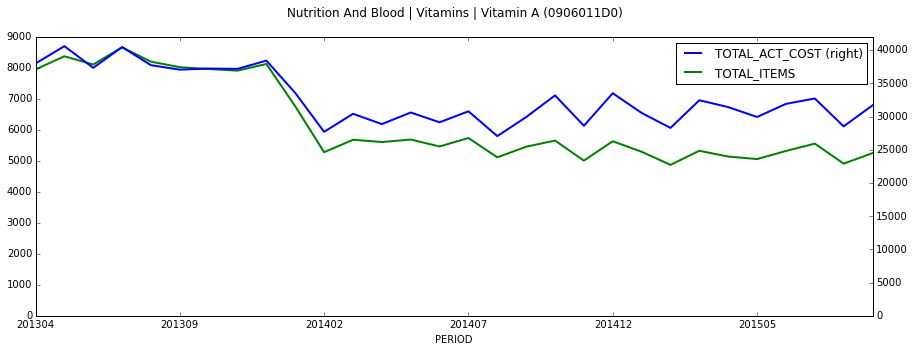

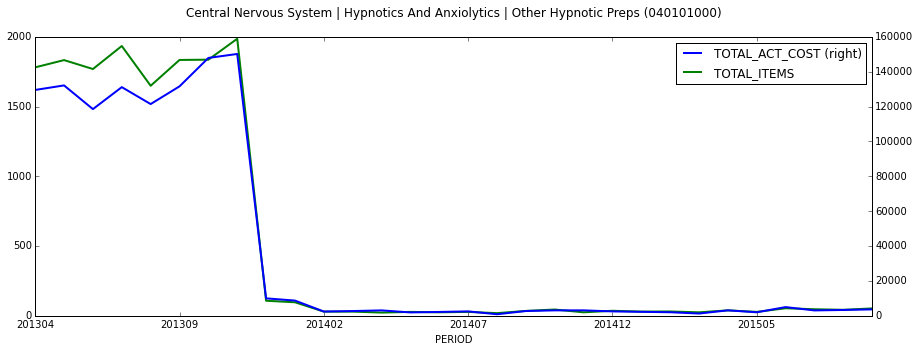

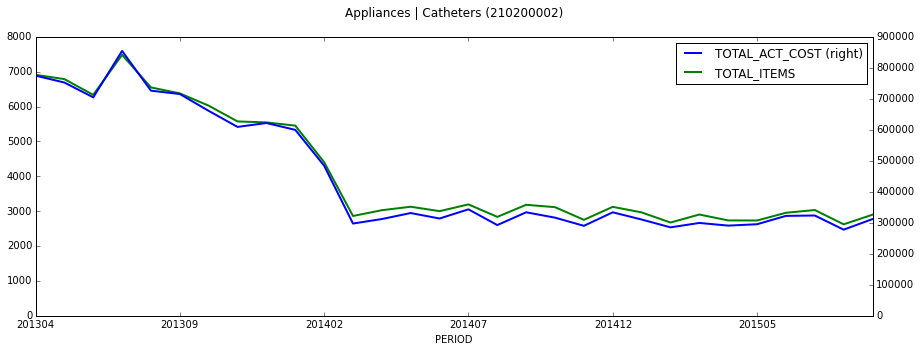

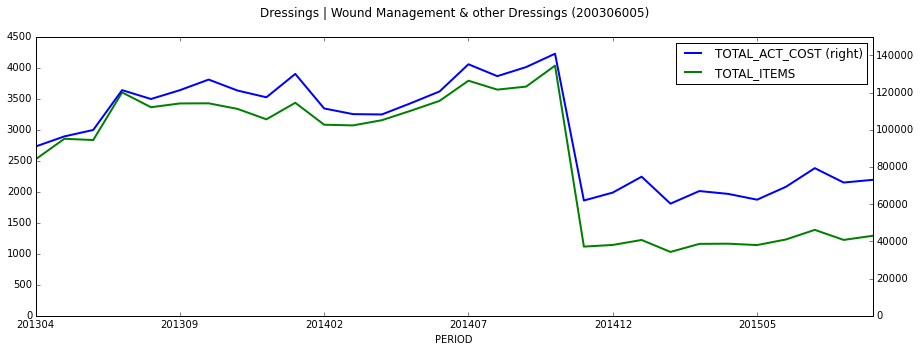

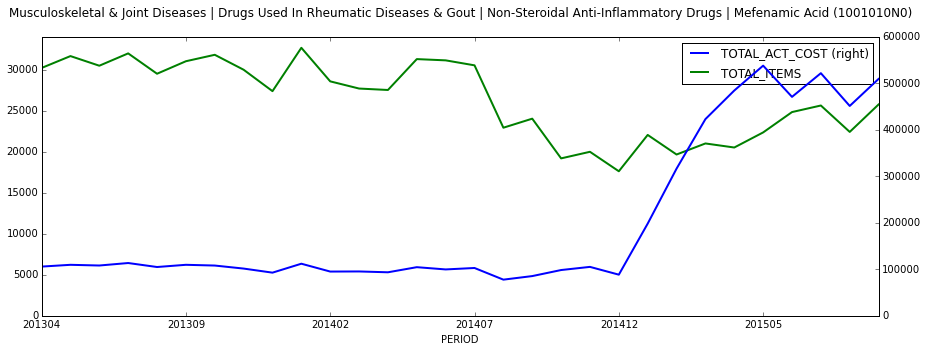

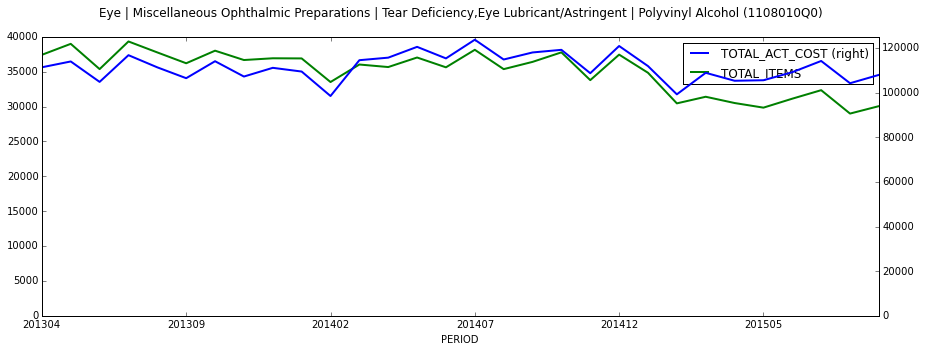

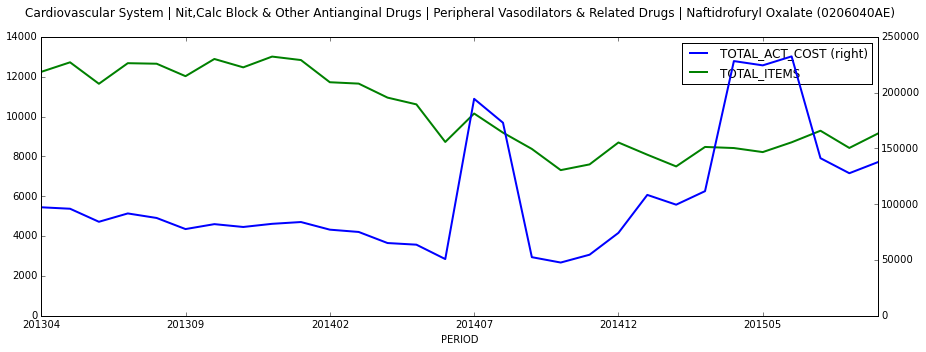

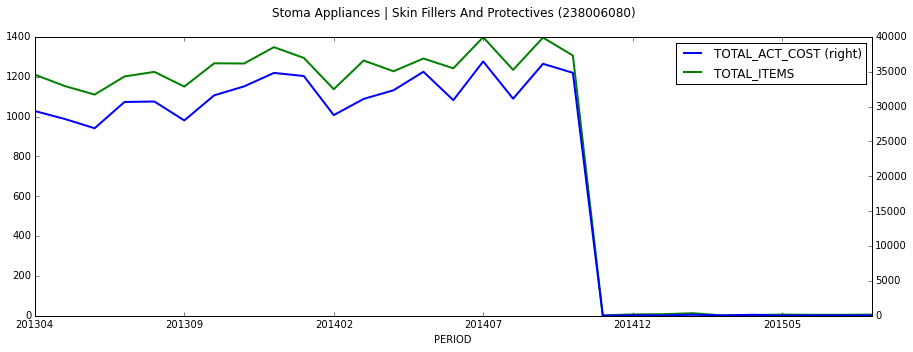

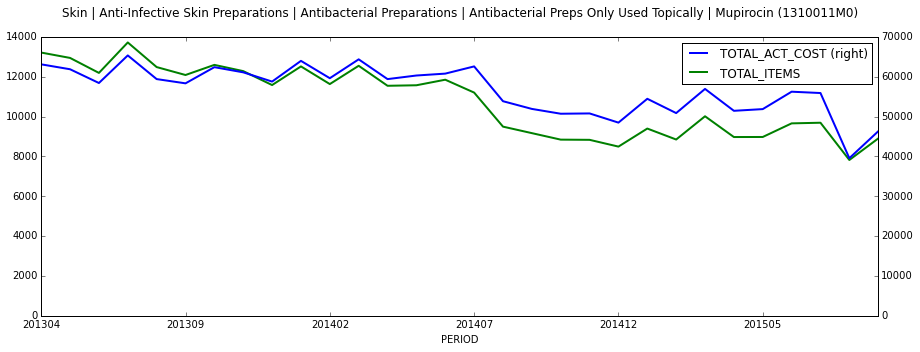

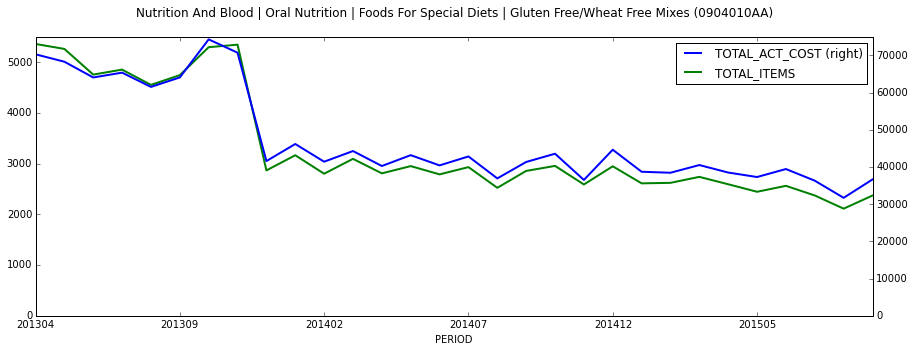

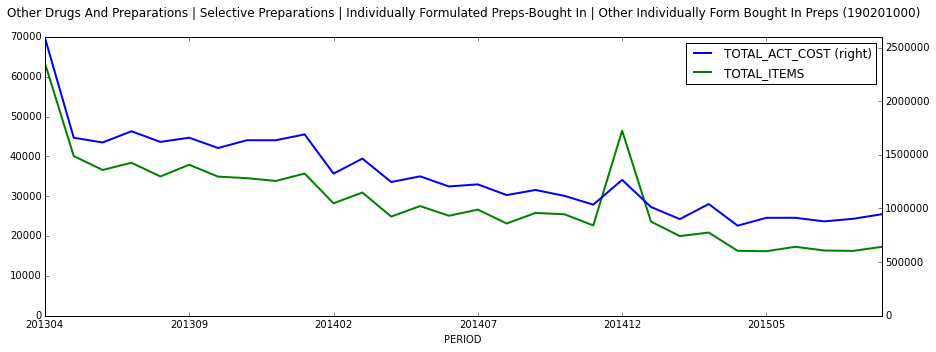

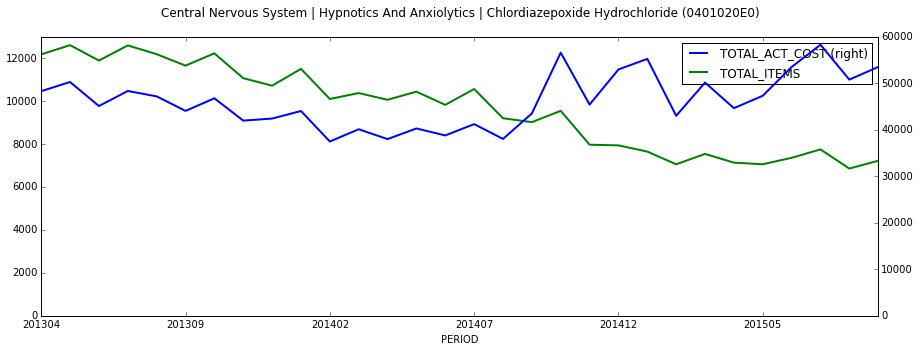

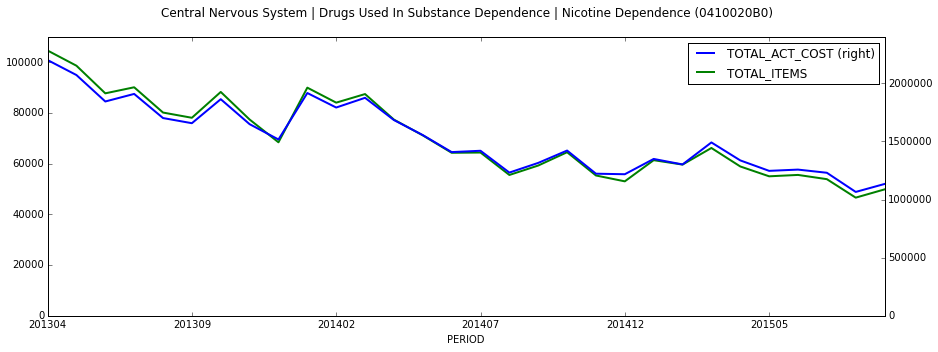

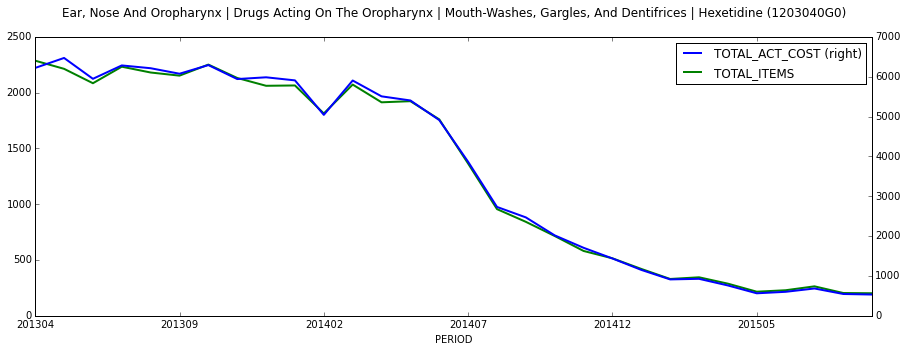

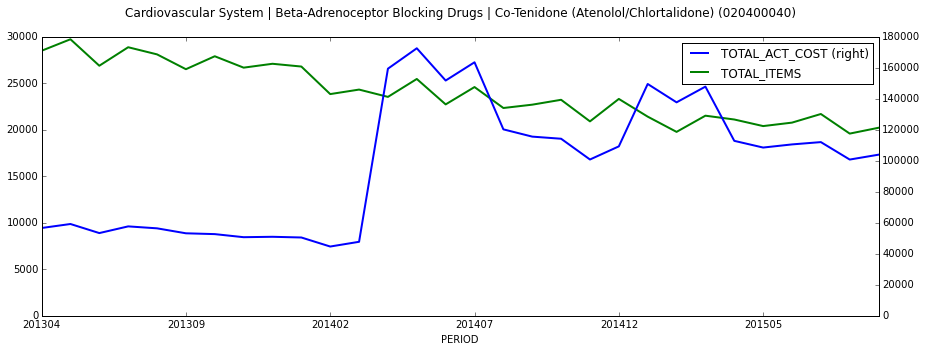

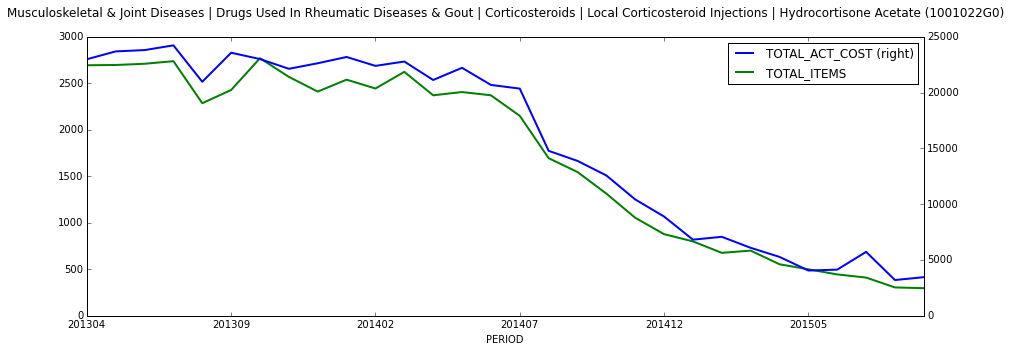

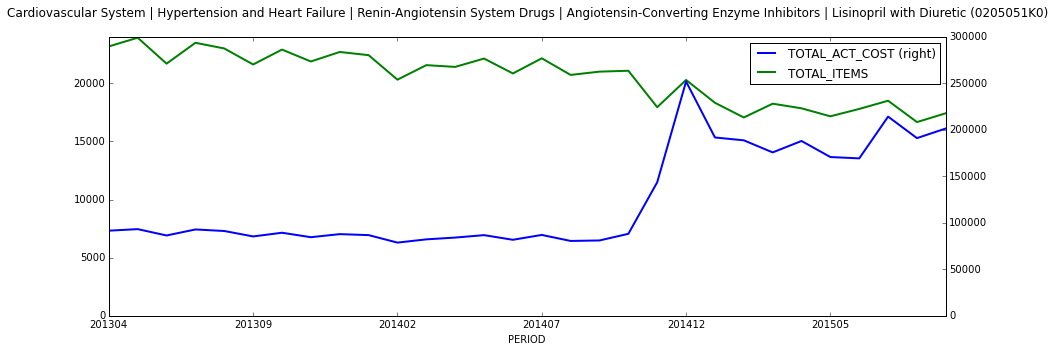

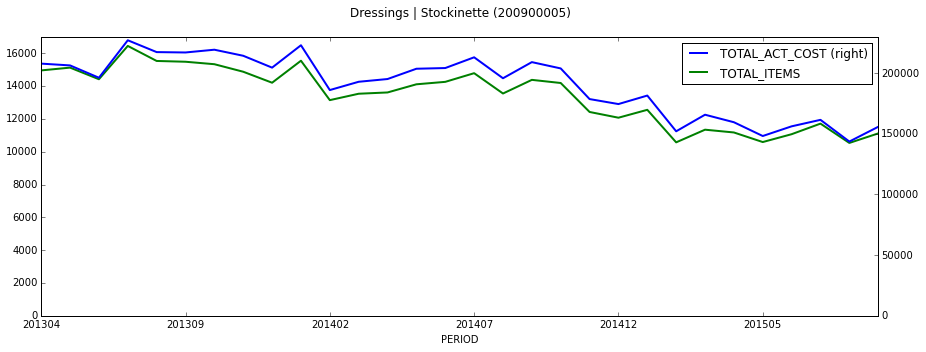

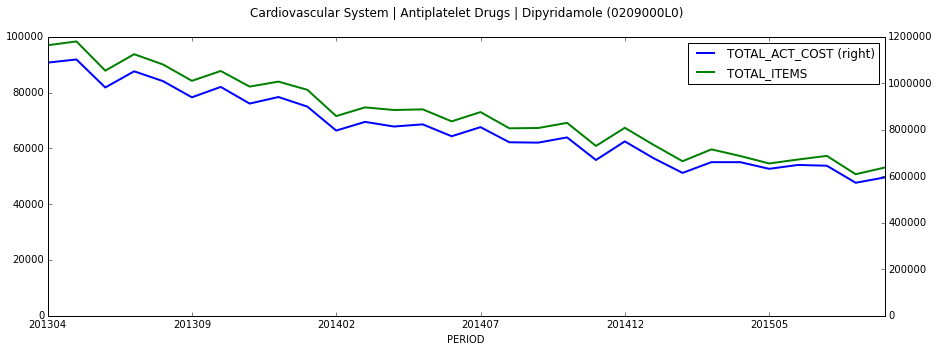

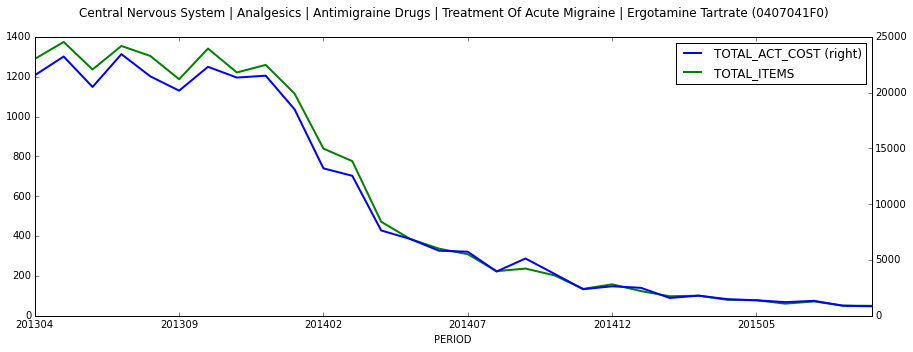

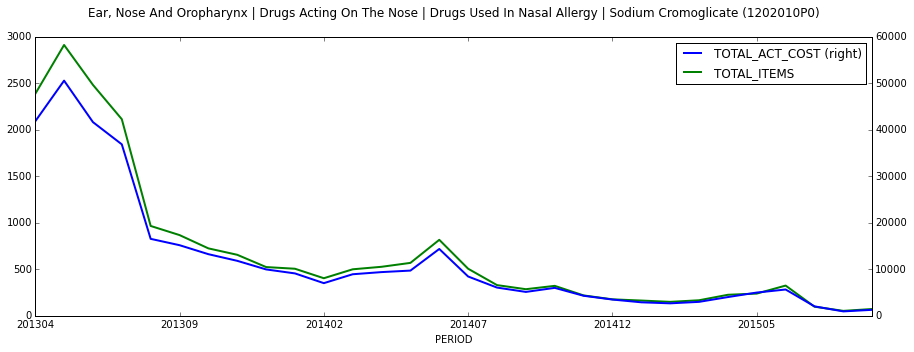

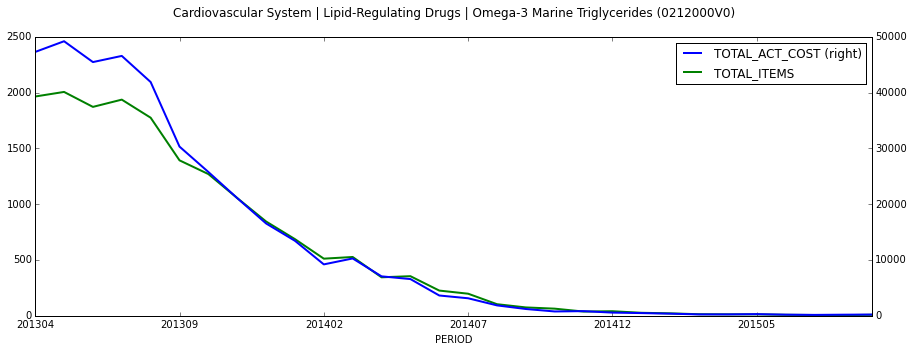

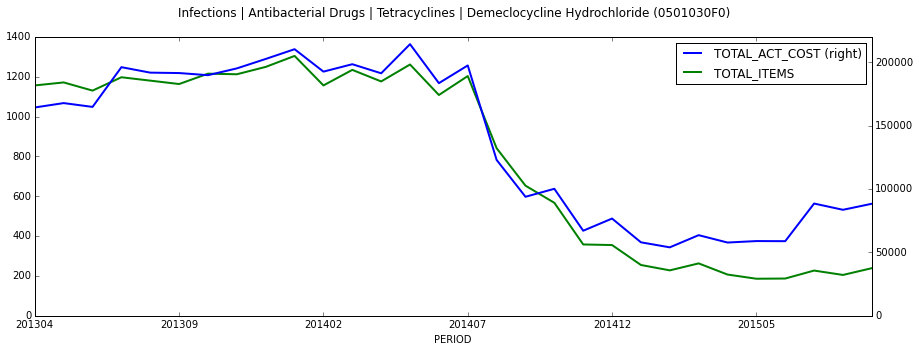

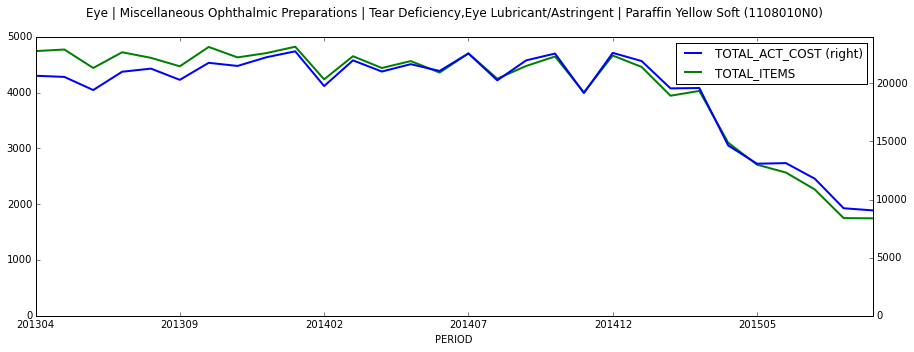

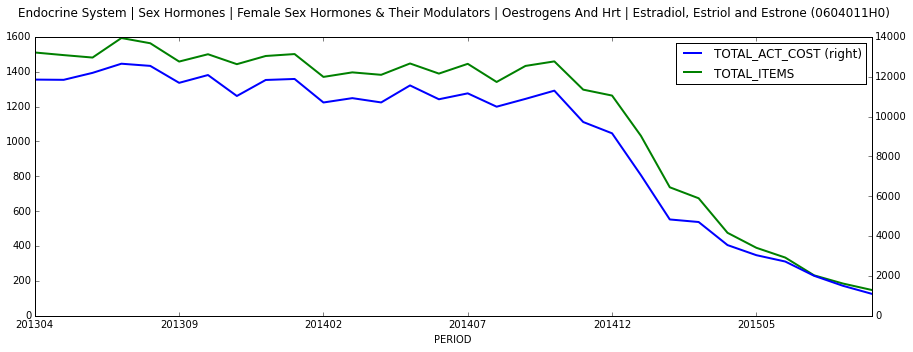

In [60]:
def score(x):
    if len(x)>12:
        try:
            ps=[p for p in range(3,len(x)-2) if np.mean(x[:p])>np.mean(x[p:])]
            if ps:
                sd=np.std(x)
                return max([sd-np.std(x[:p])-np.std(x[p:]) for p in ps])
        except Exception, e:
            print e
    else:
        return -1

#NB must sort index of df, as the score function assumes values are organised in time order (groupby preserves the order)
scores=df.sort().groupby(level=0).agg(score)
for highscorer in scores.sort(columns=['TOTAL_ITEMS'],ascending=False)[:40].index:
    ax=df.ix[highscorer].sort().plot(ylim=0,figsize=(15,5),linewidth=2,secondary_y=['TOTAL_ACT_COST'],
                                  title="%s (%s)\n" % (bnf.description(highscorer),highscorer))
    ax.right_ax.set_ylim(0)

# Log of detected chemicals

In [61]:
for highscorer in scores.sort(columns=['TOTAL_ITEMS'],ascending=False)[:40].index:
    print highscorer,bnf.path(highscorer)[-1]

0205052V0 Valsartan
0406000J0 Domperidone
1003020R0 Piroxicam
1201010G0 Hydrocortisone Acetate
0202040B0 Co-Amilofruse (Amiloride HCl/Frusemide)
1304000H0 Clobetasone Butyrate
1201010Q0 Hydrocortisone
0904010U0 Gluten Free/Wheat Free Bread
1201010F0 Flumetasone Pivalate
1003020M0 Felbinac
1003020T0 Nicotinates
0212000AB Omega-3-Acid Ethyl Esters
1001010C0 Diclofenac Sodium
0103030S0 Sucralfate
0401010T0 Temazepam
0906011D0 Vitamin A
040101000 Other Hypnotic Preps
210200002 Catheters
200306005 Wound Management & other Dressings
1001010N0 Mefenamic Acid
1108010Q0 Polyvinyl Alcohol
0206040AE Naftidrofuryl Oxalate
238006080 Skin Fillers And Protectives
1310011M0 Mupirocin
0904010AA Gluten Free/Wheat Free Mixes
190201000 Other Individually Form Bought In Preps
0401020E0 Chlordiazepoxide Hydrochloride
0410020B0 Nicotine Dependence
1203040G0 Hexetidine
020400040 Co-Tenidone (Atenolol/Chlortalidone)
1001022G0 Hydrocortisone Acetate
0205051K0 Lisinopril with Diuretic
200900005 Stockinette
02090

# 0406000J0 Domperidone

Domperidone was the subject of a MHRA safety alert

- https://www.gov.uk/drug-safety-update/domperidone-risks-of-cardiac-side-effects

If we take a look at all the drugs in its BNF section (Central Nervous System | Drugs Used In Nausea And Vertigo), it's not obvious what replaced it.

Let's select all chemicals in 4.6 and plot over time:

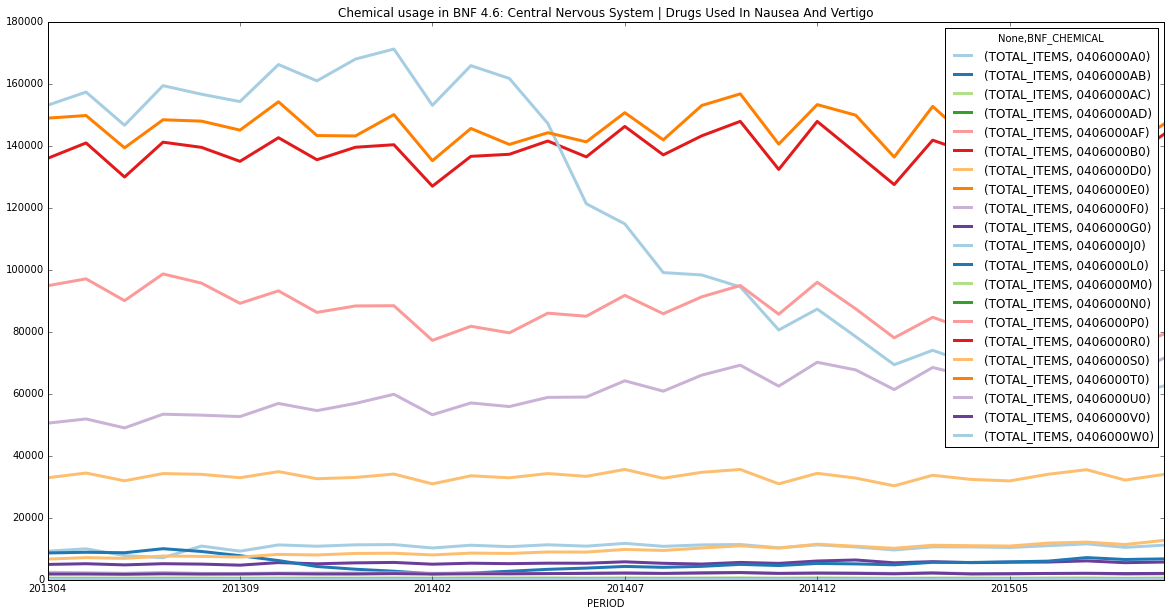

In [62]:
colors='#a6cee3,#1f78b4,#b2df8a,#33a02c,#fb9a99,#e31a1c,#fdbf6f,#ff7f00,#cab2d6,#6a3d9a'.split(',')
df[df.index.map(lambda i: i[0][:4]=="0406")].unstack(0).fillna(0)[['TOTAL_ITEMS']].\
    plot(figsize=(20,10),colors=colors,legend=True,linewidth=3,
         title="Chemical usage in BNF 4.6: Central Nervous System | Drugs Used In Nausea And Vertigo")